# Imports

In [10]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

# Get the data

We'll use the `imdb`(https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) movie review dataset as an example. 

It contains 25,000 highly polar movie reviews for training, and another 25,000 for testing. Each review is labeled as 1 (positive) or 0 (negative).

We set `num_words=5000`. Words are ranked by how often they occur (in the training set) and only the `num_words` most frequent words are kept. Any less frequent word will appear as `oov_char` value in the sequence data. If None, all words are kept. Default is None.

In [18]:
num_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

# Explore the data

In [19]:
print('Number of training samples:', len(y_train))
print('Number of positive samples', sum(y_train))
print('Number of test samples:', len(y_test))

Number of training samples: 25000
Number of positive samples 12500
Number of test samples: 25000


The raw text has already been transformed into a bag of words and each word is represented by an integer. 

The value of the integer indicates how frequently the word occurs in the dataset. For instance, "1" represents the most frequent word, while "10" represents the 10th most frequent word. 

In [20]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


We can use the word dictionary to map the integer back to the word it represents:

In [21]:
index_word = {index: word for word, index in imdb.get_word_index().items()}
print([index_word.get(i, ' ') for i in X_train[0]])

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'and', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 'have', 'critics', 'they'

# Data preprocessing

All the input sequences to an RNN model must be the same length. We now check the length of each sample (the number of words in each review):

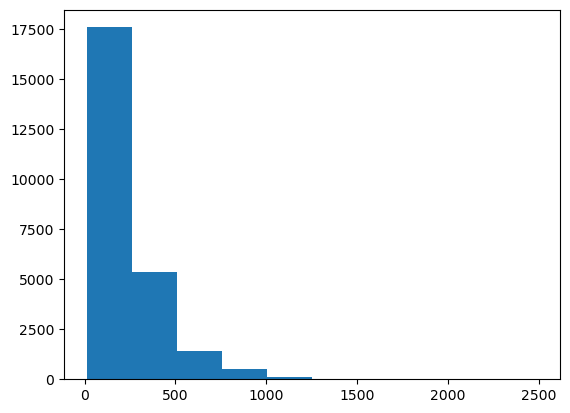

In [22]:
review_lengths = [len(x) for x in X_train]

plt.hist(review_lengths, bins=10)
plt.show()

We can see in the above plot that the majority of the reviews are around 200 words long. 

We set 200 as the universal sequence length by padding shorter reviews with zeros and truncating longer reviews. We use the `pad_sequences` function from Keras to accomplish this:

In [23]:
maxlen = 200
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [24]:
print('X_train shape after padding:', X_train.shape)
print('X_test shape after padding:', X_test.shape)

X_train shape after padding: (25000, 200)
X_test shape after padding: (25000, 200)


# RNN model

In [68]:
tf.random.set_seed(42)
model = models.Sequential()

We embed the input sequences that are made of up `num_words=5000` unique word tokens into dense vectors of size 32:

In [69]:
embedding_size = 32
model.add(layers.Embedding(num_words, embedding_size))

In [70]:
# the recurrent layers (LSTM layers)
model.add(layers.LSTM(50, return_sequences=True, dropout=0.3))
model.add(layers.LSTM(50, dropout=0.3))

In [71]:
# the output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [72]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          160000    
                                                                 
 lstm_7 (LSTM)               (None, None, 50)          16600     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 196,851
Trainable params: 196,851
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
optimizer = optimizers.Adam(lr=0.003)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [76]:
batch_size = 64
n_epoch = 7
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=n_epoch,
          validation_data=(X_test, y_test))

Epoch 1/7
391/391 [==============================] - 58s 148ms/step - loss: 0.2161 - accuracy: 0.9180 - val_loss: 0.3242 - val_accuracy: 0.8697
Epoch 2/7
391/391 [==============================] - 57s 147ms/step - loss: 0.1967 - accuracy: 0.9244 - val_loss: 0.3378 - val_accuracy: 0.8721
Epoch 3/7
391/391 [==============================] - 58s 147ms/step - loss: 0.1684 - accuracy: 0.9367 - val_loss: 0.3635 - val_accuracy: 0.8689
Epoch 4/7
391/391 [==============================] - 58s 148ms/step - loss: 0.1440 - accuracy: 0.9463 - val_loss: 0.3993 - val_accuracy: 0.8708
Epoch 5/7
391/391 [==============================] - 98s 251ms/step - loss: 0.1286 - accuracy: 0.9526 - val_loss: 0.4058 - val_accuracy: 0.8624
Epoch 6/7
391/391 [==============================] - 58s 148ms/step - loss: 0.1204 - accuracy: 0.9557 - val_loss: 0.4074 - val_accuracy: 0.8572
Epoch 7/7
391/391 [==============================] - 58s 149ms/step - loss: 0.1231 - accuracy: 0.9551 - val_loss: 0.4105 - val_accuracy:

In [77]:
acc = model.evaluate(X_test, y_test, verbose = 0)[1]
print('Test accuracy:', acc)

Test accuracy: 0.8723199963569641
